In [1]:
import pandas as pd
from utils.text import SparseTextProcessor
from nltk.tokenize import TweetTokenizer
import seaborn as sns
import nltk

# Carregando dados de análise

In [2]:
data_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [3]:
id2label = {
    0: "neutro",
    1: "positivo",
    2: "negativo"
}

In [4]:
# Convertendo ids para labels para facilitar interpretação
data_df["label"] = data_df["label"].map(id2label)

In [5]:
data_df.head()

,label,text
2403,positivo,Começou o The Noite com o Charlie Hunnam
1349,negativo,"No twitter a 3ª feira é chata,pois todo mundo ..."
5422,neutro,Bial declamando os do garçom Conversa Com Bial
1262,neutro,AI MEU DEUS É AGORA Master Chef BR
5438,negativo,A Miriam só não roda pq eu acho que o tal sorv...


# Definindo procedimento de pre-processamento de texto

Pipeline simples de pre-processamento de texto, incluindo: conversão para lower-case, remoção de stop-words e stemmização.

In [6]:
processor = SparseTextProcessor(
    TweetTokenizer().tokenize,
    lower_case=True,
    stop_words=nltk.corpus.stopwords.words("portuguese"),
    stemmer=nltk.stem.RSLPStemmer().stem
)

# Aplicando pipeline de pre-processamento

In [7]:
data_df["proc_text"] = processor.process(data_df["text"].values)

In [8]:
data_df.head()

,label,text,proc_text
2403,positivo,Começou o The Noite com o Charlie Hunnam,começ the noit charli hunn
1349,negativo,"No twitter a 3ª feira é chata,pois todo mundo ...",twitt 3ª feir chatapoil tod mund coment mast c...
5422,neutro,Bial declamando os do garçom Conversa Com Bial,bial declam garçom convers bial
1262,neutro,AI MEU DEUS É AGORA Master Chef BR,ai deu agor mast chef br
5438,negativo,A Miriam só não roda pq eu acho que o tal sorv...,mir rod pq ach tal sorvet fern vai fic merd ma...


# Conversão dos textos para representações esparsas

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
params = {
    "max_features": 10000,      # tamanho máximo de vocabulário
    "ngram_range": (1, 3)       # ngrams 
}

In [11]:
vectorizer = CountVectorizer(**params)
# vectorizer = TfidfVectorizer(**params)

In [12]:
text_vectors = vectorizer.fit_transform(data_df["proc_text"])

In [13]:
text_vectors.shape

(2463, 10000)

# Agrupamento usando K-means

In [14]:
from sklearn.cluster import KMeans

In [15]:
kmeans = KMeans(n_clusters=2, n_init=100, init='random', max_iter=500)

kmeans.fit(text_vectors.todense())

KMeans(init='random', max_iter=500, n_clusters=2, n_init=100)

In [16]:
data_df["cluster"] = kmeans.labels_

# Avaliando silhueta do agrupamento gerado

In [17]:
from sklearn.metrics import silhouette_samples
from yellowbrick.cluster.silhouette import silhouette_visualizer

In [18]:
data_df["silhouette"] = silhouette_samples(text_vectors.todense(), kmeans.labels_)

In [19]:
mean_silh = data_df["silhouette"].mean()

In [20]:
print(f"- EE: {kmeans.inertia_}")
print(f"- Mean silhouette: {mean_silh}")

- EE: 31858.407799066692
- Mean silhouette: 0.10053557256029791


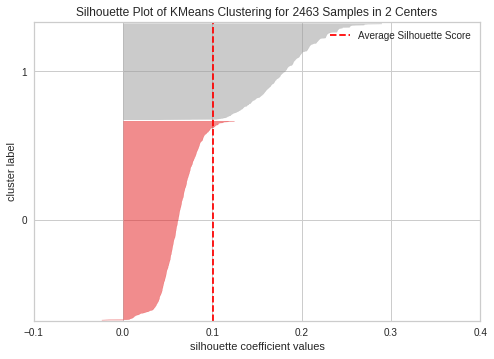

/home/kenzosaki/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7effa998d910>,
                     model=None)

In [21]:
silhouette_visualizer(
    kmeans,
    X=text_vectors.todense(),
    y=data_df["label"].values,
    is_fitted=True
)

# Visualizando distribuição das classes por cluster

In [22]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Cluster 1')

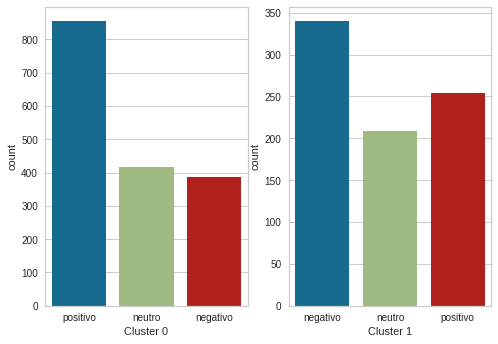

In [23]:
fig, axes = plt.subplots(1,2)

c0_df = data_df[data_df["cluster"] == 0]
c1_df = data_df[data_df["cluster"] == 1]

sns.countplot(data=c0_df, x="label", ax=axes[0])
axes[0].set_xlabel("Cluster 0")
sns.countplot(data=c1_df, x="label", ax=axes[1])
axes[1].set_xlabel("Cluster 1")